In [21]:
import networkx as nx
import numpy as np
import scipy as sp
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities
from community import community_louvain
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn import metrics

In [22]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)
print(f"number of nodes in original dataset: ", len(G0.nodes))

#removing the prefix in proteins
protein_info = pd.read_csv("Protein_info.txt", sep='\t')
map_dic = protein_info.set_index('#string_protein_id').to_dict()['preferred_name']
   
G = nx.relabel_nodes(G0, map_dic)

# remove essential proteins
essential_proteins = pd.read_csv("yeast essential proteins.csv", header=None)[1]
print()
print(essential_proteins)
G.remove_nodes_from(essential_proteins)
print(f"number of nodes after removing essential proteins: ", len(G.nodes))  

# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 500
for edge in G.edges: 
    weight = list(G.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G.remove_edge(edge[0],edge[1])

number of nodes in original dataset:  6394

0         YAL001C
1         YAL003W
2         YAL012W
3         YAL025C
4         YAL032C
          ...    
1308    YKL138C-A
1309    YNL138W-A
1310    YNL024C-A
1311    YHR199C-A
1312    YIL102C-A
Name: 1, Length: 1313, dtype: object
number of nodes after removing essential proteins:  6324


In [19]:
#protein_interest = ['YER178W', 'YBR221C', 'YNL071W', 'YOR090C', 'YFL018C', 'YIL042C', 'YGL059W']

In [20]:
#nx.common_neighbors(G, protein_interest[0], protein_interest[1])

## Louvain and Centrality Measures

In [23]:
partLouvain = community_louvain.best_partition(G)
number_of_communities = max(partLouvain.values())+1 #We add one because the indexing starts at 0.
print('# of partitions for Louvain modularity =',number_of_communities)
communities = {} #empty dictionary
for i in range(number_of_communities):
    communities[i] = [] #create an empty list for each community

for name, community in partLouvain.items():
    communities[community].append(name) #go through the computed partition and add each node to the appropriate list


# of partitions for Louvain modularity = 309


In [24]:
protein_interest = ['PDA1', 'PDB1', 'LAT1', 'LPD1', 'PKP1', 'PKP2', 'PTC5']
communities_interest = set()

for p in protein_interest:
    print(f"protein {p} in community {partLouvain[p]}")
    communities_interest.add(partLouvain[p])

#PDA1, PDB1, LAT1, LPD1, 
#PKP1, PKP2,PTC5



protein PDA1 in community 2
protein PDB1 in community 2
protein LAT1 in community 2
protein LPD1 in community 2
protein PKP1 in community 8
protein PKP2 in community 8
protein PTC5 in community 8


In [25]:
print(number_of_communities)
print(communities[309])

309


KeyError: 309

Below is a code to obtain a subset of G with only community 2 and 7

In [26]:
G_PDH = G.subgraph(communities[list(communities_interest)[0]]) #subgraph of community with PDH Complex
G_enz = G.subgraph(communities[list(communities_interest)[1]]) #subgraph of community with phosphatase and kinase

In [27]:
list(communities_interest)

[8, 2]

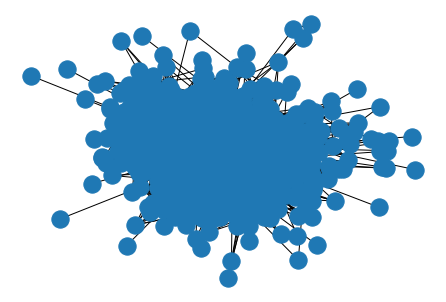

In [28]:
nx.draw(G_PDH)

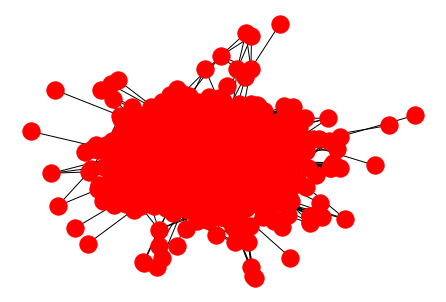

In [29]:
nx.draw(G_enz, node_color = 'red')

The code below finds the 10 nodes with the highest centrality measure within the PDH complex community

In [32]:
PDH_dict = nx.degree_centrality(G_PDH)
PDH_centrality = sorted(PDH_dict.items(), key=lambda item: item[1], reverse=True)
PDH_centrality[0:10]

[('ACT1', 0.169993117687543),
 ('CDC42', 0.16517549896765313),
 ('SEC4', 0.12732278045423262),
 ('RHO1', 0.1245698554714384),
 ('SNC1', 0.12181693048864418),
 ('YPT7', 0.11631108052305575),
 ('CHC1', 0.11355815554026152),
 ('RAS2', 0.11286992429456297),
 ('ARF1', 0.11149346180316586),
 ('YPT1', 0.1094287680660702)]

In [33]:
#using eigenvector centrality
PDH_eigen = sorted(nx.eigenvector_centrality(G_PDH).items(), key = lambda item:item[1], reverse = True)
PDH_eigen[0:10]

[('ACT1', 0.13922419333470626),
 ('SNC1', 0.12766256657277794),
 ('SEC4', 0.12547472662141212),
 ('CDC42', 0.12260878798343186),
 ('YPT1', 0.11541200353083689),
 ('ARF1', 0.11183904808712254),
 ('YPT7', 0.11086007803448963),
 ('CHC1', 0.10965644808229238),
 ('RHO1', 0.10065494481113132),
 ('SEC22', 0.1003249838099733)]

Look at degree distribution next?

We repeat the same process for the kinase and phosphatase community

In [34]:
Enz_dict = nx.degree_centrality(G_enz)
Enz_centrality = sorted(Enz_dict.items(), key=lambda item: item[1], reverse=True)
Enz_centrality[0:10]

[('PGM2', 0.1176853055916775),
 ('ZWF1', 0.11118335500650195),
 ('TRP5', 0.10728218465539661),
 ('TPI1', 0.10728218465539661),
 ('CTT1', 0.10403120936280885),
 ('NQM1', 0.10273081924577374),
 ('PGK1', 0.10208062418725618),
 ('GAD1', 0.10143042912873862),
 ('ALD3', 0.09947984395318596),
 ('TRP3', 0.09557867360208062)]

In [35]:
Enz_eigen = sorted(nx.eigenvector_centrality(G_enz).items(), key = lambda item:item[1], reverse = True)
Enz_eigen[0:5]

[('ZWF1', 0.1314314279919832),
 ('TPI1', 0.1305512158261875),
 ('PGM2', 0.12519080757059656),
 ('PGK1', 0.11902119273718667),
 ('NQM1', 0.11772601229019954)]

In [36]:
for p in Enz_centrality:
    if p[0] in protein_interest:
        print(p)

('PDB1', 0.0741222366710013)
('PDA1', 0.06306892067620286)
('LPD1', 0.04746423927178153)
('LAT1', 0.04551365409622887)


In [37]:
for p in PDH_centrality:
    if p[0] in protein_interest:
        print(p)

('PTC5', 0.019958706125258085)
('PKP1', 0.01032346868547832)
('PKP2', 0.009635237439779766)


In [38]:
for p in Enz_eigen:
    if p[0] in protein_interest:
        print(p)

('PDB1', 0.09552874553085511)
('PDA1', 0.08705223389690823)
('LPD1', 0.06227286646058195)
('LAT1', 0.05245652110392205)


In [39]:
for p in PDH_eigen:
    if p[0] in protein_interest:
        print(p)

('PTC5', 0.007207466819000953)
('PKP1', 0.0028042598793163887)
('PKP2', 0.0027444187798973756)


In [40]:
Enz_eigen[-1]

('YBL096C', 5.780615360637166e-07)

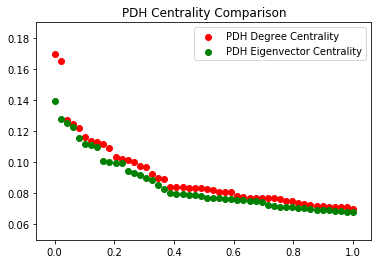

In [63]:
# Comparing degree centrality with eigenvector centrality for PDH
intervals = np.linspace(0, 1, 100)
deg_c = []
eigen_c = []
for i in range(0, 50):
    deg_c.append(PDH_centrality[i][1])
    eigen_c.append(PDH_eigen[i][1])

plt.title("PDH Centrality Comparison")
plt.scatter(intervals, deg_c, color='r', label="PDH Degree Centrality")
plt.scatter(intervals, eigen_c, color='g', label="PDH Eigenvector Centrality")
plt.legend()
plt.show()

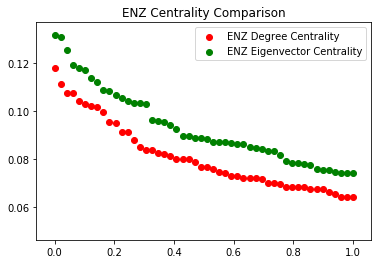

In [64]:
# Comparing degree centrality with eigenvector centrality for ENZ
intervals = np.linspace(0, 1, 50)
deg_c_enz = []
eigen_c_enz = []
for i in range(0, 50):
    deg_c_enz.append(Enz_centrality[i][1])
    eigen_c_enz.append(Enz_eigen[i][1])

plt.title("ENZ Centrality Comparison")
plt.scatter(intervals, deg_c_enz, color='r', label="ENZ Degree Centrality")
plt.scatter(intervals, eigen_c_enz, color='g', label="ENZ Eigenvector Centrality")
plt.legend()
plt.show()